# Transfer Learning 

(with a very large pre-trained convolutional network (VGG-16) on a small dataset of natural images)


We abandon MNIST for a more complex dataset of natural images of ants and bees. The task is of course telling ants from bees (A from B).

<img src="../NotebooksFigures/ants_and_bees.jpg" alt="drawing" width="600" >

Being the data much more complex we will need a very large convolutional network to do the job, but at the same time - since our dataset is relatively small (a few hundred images between training and validation set) - we cannot train it from scratch.
Having observed that the first layers of a large convolutional network learn representations which can be universally useful for object recognition purposes, we will take a very large one that will help us.
Specifically, we will use a VGG-16 pre-trained on ImageNet as a feature extractor.

<img src="../NotebooksFigures/vgg16.png" alt="drawing" width="200" >


On top of the VGG-16 - maimed of its classifier stack - we will add a brand new classifier stack with the correct output shape, train it for a few epochs, and finally test it on our data.

This operation is commonly denoted *Transfer Learning*.



EXCERCISE :

- construct the classifier and train it 
- test it
- modify n.of layers
- point to other more sophisticated examples


In this exercise we will learn how to :

- download a pre-trained model
- prepare a dataset for a (binary) classification problem
- extract the representations (features) at the end of the convolutional stack
- fit a classifier stack to the new dataset, this classifier will be identical to the classifier stack of the original VGG-16, a part from the output shape
- evaluate the model obtained on validation data
- look at the errors made by the network i.e. false ants and false bees

In [1]:
from __future__ import print_function


%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img

Using TensorFlow backend.


# Instantiate a pre-trained VGG-16 without its classifier stack

In [2]:
from keras.applications import VGG16
vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
train_dir = '/home/qsb/Winter_School_QSB_2018/data/hymenoptera_data/train'
validation_dir = '/home/qsb/Winter_School_QSB_2018/data/hymenoptera_data/val'

nTrain = 600
nVal = 150

In [6]:
#delete 4 images from train/ants

# this will be slow without a GPU

datagen = ImageDataGenerator(rescale=1./255)

In [9]:
244./4

61.0

In [10]:
batch_size = 4

train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,2))

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 244 images belonging to 2 classes.


In [11]:
i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    print(i*batch_size)
    if i * batch_size >= nTrain:
        break
        
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


In [13]:
batch_size = 10

validation_features = np.zeros(shape=(nVal, 7, 7, 512))
validation_labels = np.zeros(shape=(nVal,2))

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 153 images belonging to 2 classes.


In [14]:
i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    print(i*batch_size)
    if i * batch_size >= nVal:
        break

validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512))

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


In [15]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features,validation_labels))

Train on 600 samples, validate on 150 samples
Epoch 1/20
600/600 [==============================] - 18s 31ms/step - loss: 1.1508 - acc: 0.7150 - val_loss: 0.4572 - val_acc: 0.8200
Epoch 2/20
600/600 [==============================] - 22s 37ms/step - loss: 0.2905 - acc: 0.8983 - val_loss: 0.4297 - val_acc: 0.8467
Epoch 3/20
600/600 [==============================] - 27s 46ms/step - loss: 0.1921 - acc: 0.9200 - val_loss: 0.5031 - val_acc: 0.8400
Epoch 4/20
600/600 [==============================] - 14s 24ms/step - loss: 0.1082 - acc: 0.9633 - val_loss: 0.4966 - val_acc: 0.8533
Epoch 5/20
600/600 [==============================] - 14s 24ms/step - loss: 0.0539 - acc: 0.9817 - val_loss: 1.3844 - val_acc: 0.7200
Epoch 6/20
600/600 [==============================] - 14s 24ms/step - loss: 0.0790 - acc: 0.9700 - val_loss: 0.6304 - val_acc: 0.8333
Epoch 7/20
600/600 [==============================] - 15s 24ms/step - loss: 0.0132 - acc: 0.9950 - val_loss: 0.9008 - val_acc: 0.8067
Epoch 8/20
600/6

In [16]:
fnames = validation_generator.filenames

ground_truth = validation_generator.classes

label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

In [17]:
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)

In [18]:
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 1/150


/home/qsb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


Original label:ants, Prediction :ants, confidence : 1.000


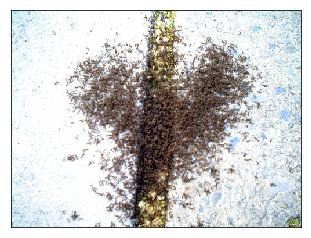

In [19]:
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.xticks([])
    plt.yticks([])
    plt.show()